# Configuration interaction

## Full CI

As we saw in the previous section, for an exact state, we have the formula:

\begin{equation*}
  \langle \langle \hat{\Omega}; \hat{V}^{\omega} \rangle
  \rangle  = -
  \frac{1}{\hbar} \sum_{n>0} \left[
  \frac{\langle 0 | \hat{\Omega}  | n \rangle 
	\langle n | \hat{V}^{\omega} | 0 \rangle }
       {\omega_{n0}-\omega}
+
  \frac{\langle 0 | \hat{V}^{\omega}  | n \rangle 
	\langle n | \hat{\Omega} | 0 \rangle }
       {\omega_{n0}+\omega} \right] .
\end{equation*}

For example, in the case of a molecule iradiating by light, we are interested in computing the polarizability $\alpha_{\alpha\beta}(-\omega; \omega)$, corresponding to the response with $\hat{\Omega} = \hat{\mu}_\alpha$ and $\hat{V}^\omega = - \hat{\mu}_\beta$. Looking more precisely at the isotropic component, $\bar\alpha (-\omega; \omega) = \frac{1}{3} \sum_\alpha \alpha_{\alpha\alpha} (-\omega; \omega)$, we obtain:

\begin{equation*}
  \bar\alpha (-\omega; \omega) = \frac{2}{3} \sum_{n>0} \sum_\alpha \frac{ \omega_{n0} \langle 0 | \hat{\mu}_\alpha  | n \rangle^2 }{ \omega_{n0}^2 - \omega^2 }
\end{equation*}

We now define the oscillator strength $f_n$ for a transition $0 \rightarrow n$ as:
\begin{equation*}
  f_n =  \frac{2}{3} \sum_\alpha \omega_{n0} \langle 0 | \hat{\mu}_\alpha  | n \rangle^2
\end{equation*}

such that
\begin{equation*}
  \bar\alpha (-\omega; \omega) =  \sum_{n>0}  \frac{ fn }{ \omega_{n0}^2 - \omega^2 }
\end{equation*}

Those formulas can be applied directly for a configuration interaction wavefunction, where it is easy to get the excited state energies simply by obtaining additional roots in the diagonalization of the Hamiltonian. We then only need to compute the matrix element $\langle 0 | \hat{\mu}_\alpha  | n \rangle$. In second quantization, the dipole operator can be written:

\begin{equation*}
\hat{\mu}_{\alpha} = \sum_{pq} \mu_{\alpha pq} \hat{a}_p^\dagger \hat{a}_q .
\end{equation*}

We thus need to compute the matrix $\gamma$, with elements $ \gamma_{pq} =\langle 0 |\hat{a}_p^\dagger \hat{a}_q | n \rangle$, which is called the transition density matrix, and contract it with the dipole moment integrals.


Let's apply these for fullCI of a water molecule:

In [1]:
import veloxchem as vlx
import multipsi as mtp
import numpy as np

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


In [3]:
# Compute the 5 lowest states of water using full CI

mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
basis = vlx.MolecularBasis.read(molecule, "6-31g")

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)

space=mtp.OrbSpace(molecule,scf_drv.mol_orbs)
space.CAS(8,12) #FullCI with frozen 1s orbital

nstates=5
cidrv=mtp.CIDriver(molecule,basis,space)
cidrv.compute(nstates)

CIVecs=cidrv.vecs

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 1
Number of active orbitals:              12
Number of virtual orbitals:             0

    This is a CASSCF wavefunction: CAS(8,12)

          CI expansion:
          -------------
Number of determinants:      122760



        CI Iterations
        -------------

Iteration   Average energy      Time
     1        -75.70818500   0:00:00
     2        -75.79312782   0:00:00
     3        -75.79986118   0:00:00
     4        -75.80050854   0:00:00
     5        -75.80056538   0:00:00
     6        -75.80057423   0:00:01
     7        -75.80057513   0:00:00
     8        -75.80057529   0:00:01
     9        -75.80057533   0:00:00
    10        -75.80057534   0:00:00
    11        -75.80057534   0:00:00
Convergence reached in 11 iterations

        Final results
        -------------

* State 1
- Energy: -76.12020540305302
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbitals


In [4]:
au2ev = 27.211386

#Get the molecular orbitals within the active space
C=space.getMOAct()

#Compute dipole integrals in AO basis
dipole_drv = vlx.ElectricDipoleIntegralsDriver()
dipole_mats = dipole_drv.compute(molecule, basis)
dipole=[dipole_mats.x_to_numpy(),dipole_mats.y_to_numpy(),dipole_mats.z_to_numpy()]

#Transform to MO basis
dipole_mo=[]
for icomp in range(0,3):
    dipole_mo.append(np.einsum('pq,pt,qu->tu', dipole[icomp], C, C))
    

#Initialize the CIOperator class to compute the transition densities.
expansion=mtp.CIExpansion(space)
DenDriver=mtp.CIOperator(molecule,basis,expansion)
        
#Compute all 0->n transitions
for n in range(1,nstates):
    dE=CIVecs[n].energy-CIVecs[0].energy
    tden=DenDriver.get1den(CIVecs[0],CIVecs[n]) #Transition density matrix
    dx=np.tensordot(tden,dipole_mo[0]) #<0|x|n>
    dy=np.tensordot(tden,dipole_mo[1]) #<0|y|n>
    dz=np.tensordot(tden,dipole_mo[2]) #<0|z|n>
    F=2/3*dE*(dx*dx+dy*dy+dz*dz)
    print("Excitation 0->",n," energy:",dE*au2ev,"eV oscillator strength:",F)

Excitation 0-> 1  energy: 8.449918235998382 eV oscillator strength: 0.013189367950823755
Excitation 0-> 2  energy: 10.684505582217499 eV oscillator strength: 2.0947806448205617e-27
Excitation 0-> 3  energy: 10.976544621149094 eV oscillator strength: 0.1153538024848431
Excitation 0-> 4  energy: 13.376916731575843 eV oscillator strength: 0.11498821812119465


We thus obtain 3 visible transitions and one dark state (near-zero dipole oscillator strength). We obtain the exact same result by using the built-in class of multipsi:

In [5]:
SI=mtp.InterState(molecule,basis,CIVecs)
DipOsc=SI.diposc()


List of oscillator strengths greather than 1e-10

  From     to       Energy (eV)    Oscillator strength (length and velocity)
Transition Density Matrix
[[0.00000 0.00000 -0.00000 -0.00232 0.00000 -0.00000 0.00000 0.00239
  -0.00000 -0.00000 -0.00000 0.00000]
 [-0.00000 -0.00000 -0.00000 0.00000 -0.00000 -0.00000 0.00000 0.00000
  0.00000 -0.00000 -0.00000 -0.00000]
 [0.00000 0.00000 0.00000 -0.00147 -0.00000 0.00000 0.00000 -0.00655
  -0.00000 0.00000 0.00000 -0.00000]
 [-0.01687 0.00000 -0.02794 -0.00000 -1.35728 0.00000 0.00000 -0.00000
  0.09882 -0.01411 0.00000 -0.04427]
 [0.00000 0.00000 0.00000 0.02049 0.00000 -0.00000 0.00000 -0.00128
  -0.00000 0.00000 -0.00000 0.00000]
 [0.00000 0.00000 -0.00000 -0.00000 -0.00000 0.00000 -0.00000 0.00000
  0.00000 -0.00000 -0.00000 -0.00000]
 [0.00000 0.00000 -0.00000 -0.00000 -0.00000 0.00000 -0.00000 0.00000
  0.00000 -0.00000 -0.00000 -0.00000]
 [0.00096 -0.00000 0.01747 -0.00000 -0.03174 0.00000 -0.00000 -0.00000
  -0.00340 0.00180 -0.00

## Truncated CI response
While they do not qualify as "exact state", the response equations for truncated CI are the same as the exact case above. One can thus, in principle, obtain a hierarchy of method from CIS to fullCI. However, the excitation energies do not necessarily improve from order to order. Let us demonstrate this on the water example.

In [6]:
nstates=5
Energies=np.empty((5,nstates-1)) #nstates-1 transitions for CIS, CISD, CISDT and CISDTQ and FCI
Energies[4,:]=au2ev*DipOsc['energies'] #Save the FullCI result
#CIS to CISDTQ
for exc in range(1,5):
    space=mtp.OrbSpace(molecule,scf_drv.mol_orbs)
    space.CI(exc)

    cidrv=mtp.CIDriver(molecule,basis,space)
    cidrv.compute(nstates)

    SI=mtp.InterState(molecule,basis,cidrv.vecs)
    DipOsc=SI.diposc()
    
    Energies[exc-1,:]=au2ev*DipOsc['energies']


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 0
Number of active orbitals:              13
Number of virtual orbitals:             0

    This is a GASSCF wavefunction
           
         Cumulated   Min cumulated    Max cumulated 
 Space    orbitals      occupation       occupation
     1           5               9               10
     2          13              10               10


          CI expansion:
          -------------
Number of determinants:      41



        CI Iterations
        -------------

Iteration   Average energy      Time
     1        -75.64268289   0:00:00
Convergence reached in 1 iterations

        Final results
        -------------

* State 1
- Energy: -75.98387037576917
- S^2   : -0.00  (multiplicity = 1.0 )
- Natural orbitals
[2.00000 2.00000 2.00000 2.00000 2.00000 0.00000 0.00000 0.00000 0.00000
 -0.00000 -0.00000 -0.00000 -0.00000]

* State 2
- Energy: -75.63914731810543
- S^2   : -0


        CI Iterations
        -------------

Iteration   Average energy      Time
     1        -75.70806791   0:00:00
     2        -75.73984712   0:00:00
     3        -75.74103507   0:00:00
     4        -75.74106383   0:00:00
     5        -75.74106487   0:00:00
     6        -75.74106491   0:00:00
     7        -75.74106491   0:00:00
Convergence reached in 7 iterations

        Final results
        -------------

* State 1
- Energy: -76.11428504000882
- S^2   : -0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.99996 1.98981 1.98359 1.97574 1.97266 0.02407 0.02277 0.01542 0.01054
 0.00268 0.00195 0.00046 0.00034]

* State 2
- Energy: -75.73536042873052
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.99999 1.99829 0.99907 1.99600 1.99111 0.01175 0.99382 0.00147 0.00171
 0.00118 0.00082 0.00035 0.00444]

* State 3
- Energy: -75.65422331203953
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.99999 1.99830 0.99900 1.99144 1.99450 0.99166 0.01389 0.00154 0.0014

     1        -75.70818500   0:00:01
     2        -75.78792055   0:00:00
     3        -75.79280129   0:00:01
     4        -75.79307568   0:00:02
     5        -75.79309789   0:00:00
     6        -75.79309968   0:00:01
     7        -75.79309982   0:00:00
     8        -75.79309984   0:00:00
Convergence reached in 8 iterations

        Final results
        -------------

* State 1
- Energy: -76.1152816346056
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.99996 1.98961 1.98329 1.97496 1.97170 0.02475 0.02336 0.01561 0.01071
 0.00289 0.00208 0.00060 0.00047]

* State 2
- Energy: -75.8008979183449
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.99996 1.99160 0.99537 1.98190 1.97004 0.03026 0.99592 0.00554 0.00820
 0.00318 0.00238 0.00236 0.99592]

* State 3
- Energy: -75.71977984057027
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.99996 1.99112 0.99537 1.97322 1.98000 0.99428 0.03031 0.00552 0.00953
 0.00338 0.00197 0.01222 0.00311]

* State 4
- 

     1        -75.70818500   0:00:04
     2        -75.79401156   0:00:05
     3        -75.79984012   0:00:04
     4        -75.80033568   0:00:03
     5        -75.80037556   0:00:03
     6        -75.80038084   0:00:03
     7        -75.80038135   0:00:04
     8        -75.80038144   0:00:03
     9        -75.80038146   0:00:04
    10        -75.80038146   0:00:03
Convergence reached in 10 iterations

        Final results
        -------------

* State 1
- Energy: -76.1209504707015
- S^2   : -0.02  (multiplicity = 1.0 )
- Natural orbitals
[1.99996 1.98833 1.98080 1.97165 1.96822 0.02803 0.02649 0.01800 0.01210
 0.00308 0.00221 0.00062 0.00049]

* State 2
- Energy: -75.80920379756229
- S^2   : -0.03  (multiplicity = 0.9 )
- Natural orbitals
[1.99996 1.99042 0.99448 1.97925 1.96632 0.03405 0.99598 0.00646 0.00935
 0.00351 0.00257 0.00243 0.99598]

* State 3
- Energy: -75.72711711630105
- S^2   : -0.03  (multiplicity = 0.9 )
- Natural orbitals
[1.99996 1.98983 0.99453 1.96973 1.97787 

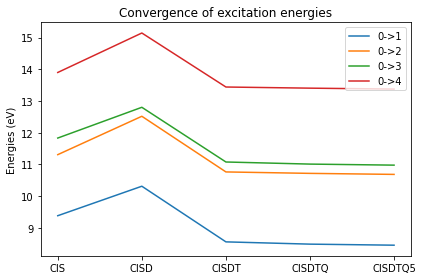

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
x = np.array(range(1,6))
plt.plot(x,Energies[:,0], label='0->1')
plt.plot(x,Energies[:,1], label='0->2')
plt.plot(x,Energies[:,2], label='0->3')
plt.plot(x,Energies[:,3], label='0->4')
plt.title('Convergence of excitation energies')
plt.xticks([1, 2, 3, 4, 5], ['CIS', 'CISD', 'CISDT', 'CISDTQ', 'CISDTQ5'])
plt.ylabel("Energies (eV)")
plt.legend()
plt.tight_layout(); plt.show()

As we can see, we do not have a clear convergence towards the fullCI result. In particular, CISD is actually worse than CIS. The reason for this is that CIS has a more even-handed treatment of the ground and excited states than CISD. In CIS, due to the Brillouin theorem, the ground state does not improve with the inclusion of single excitations, but the single excitations are needed to generate the dominant configuration for the (singly) excited states. Both ground and excited states are thus treated at a mean-field (HF) level.

However, in CISD, the ground state contains double excitation, and thus dynamical correlation, while the excited states would need up to triple excitations to both generate the singly-excited dominant configuration and correlating double excitations on top. There is an unbalance, the ground state being described more accurately than the excited states, leading to too high excitation energies. Adding the triple excitations bring correlation also for excited states, which brings the result closer to the final FullCI result, and in this simple case is essentially converged.

For this reason, while CIS is used (and as we can see in the next section, is actually related to HF response), the other truncated CIs are not.

## MCSCF and state-averaging

As for truncated CI, the exact state response formulas also apply to multiconfigurational CI. The method can thus create all excited states that arise from excitations within the active space. This can also be used as an approximation for a MCSCF response, neglecting thus the orbital part of the response.

Let us try it on our water case. We'll use an active space including the 2 pairs of O-H $\sigma$ and $\sigma^*$ (4 electrons in 4 orbitals). However, since the main excitation also involves the oxygen lone pair, we add this orbital too, for a total CAS(6,5).

First, we try the intuitive concept of first optimizing the CASSCF wavefunction for the ground state, and then applying CASCI response with the 5 states.

In [15]:
space=mtp.OrbSpace(molecule,scf_drv.mol_orbs)
space.CAS(6,5) #3 O_2p and 2 H_1s
# CASSCF calculation
mcscf_drv=mtp.McscfDriver(molecule,basis,space)
mcscf_drv.compute(1)

# CASCI excitation energies
cidrv=mtp.CIDriver(molecule,basis,space)
cidrv.compute(nstates)

# Transition properties
SI=mtp.InterState(molecule,basis,cidrv.vecs)
DipOsc=SI.diposc()


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55



        MCSCF Iterations
        ----------------

  Iter.     Avg. energy   E. change   CI iter     Time
     1    -75.99131203     0.0e+00         1    0:00:00
     2    -76.00616634    -1.5e-02         1    0:00:00
     3    -76.03223738    -2.6e-02         1    0:00:00
     4    -76.03493620    -2.7e-03         1    0:00:00
     5    -76.03751642    -2.6e-03         1    0:00:00
     6    -76.03771243    -2.0e-04         1    0:00:00
     7    -76.03780297    -9.1e-05         1    0:00:00
     8    -76.03783973    -3.7e-05         1    0:00:00
     9    -76.03784250    -2.8e-06         1    0:00:00
    10    -76.03784327    -7.7e-07         1    0:00:00
    11  


Total MCSCF time: 00:00:00

          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55



        CI Iterations
        -------------

Iteration   Average energy      Time
     1        -75.35812304   0:00:00
Convergence reached in 1 iterations

        Final results
        -------------

* State 1
- Energy: -76.03784333903573
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.99931 1.97806 1.97495 0.02400 0.02369]

* State 2
- Energy: -75.35361191561556
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.00000 1.97467 1.98958 1.00239 0.03337]

* State 3
- Energy: -75.34951016265796
- S^2   : -0.00  (multiplicity = 1.0 )
- Natural orbitals
[1.00000 1.99202 1.97078 0.03398 1.00322]

* State 4
- Energy: -75.059

In [22]:
print("FullCI Energies")
print(Energies[4,:])
print()
print("CIS Energies")
print(Energies[0,:])
print()
print("CASCI Energies")
print(au2ev*DipOsc['energies'])

FullCI Energies
[8.44992 10.68451 10.97654 13.37692]

CIS Energies
[9.38039 11.30739 11.83165 13.90150]

CASCI Energies
[18.61889 18.73050 26.61540 28.51588]


As we can see, the result is very disappointing, very far from the fullCI result, and even from the CIS result. The reason for that is the orbitals. The orbitals were optimized for the ground state, and not for the excited states. In particular, in this case, the $\sigma^*$ orbitals are optimal to describe correlation in the O-H bonds, but not for the electronic excitation.

Ideally, we would want each state to have its own orbitals, which a full MCSCF response will provide. However, there is a way to improve the result without including the orbital response. The concept is to use only one orbital set, but to make these orbitals a "compromise" between the needs of the ground state and that of the excited states. The way to do this is to construct a "state-average" (SA), that is optimize the orbitals to minimize the average energy of all states.

Doing this requires only a trivial modification of the code, namely the CI part of the MCSCF includes all states (here 5) and then the MCSCF energy is replaced by the average energy of all states and the CI densities are replaced by the average density of all states.

Let's see it in practice:

In [25]:
space=mtp.OrbSpace(molecule,scf_drv.mol_orbs)
space.CAS(6,5) #3 O_2p and 2 H_1s
# CASSCF calculation
mcscf_drv=mtp.McscfDriver(molecule,basis,space)
mcscf_drv.compute(5) #5 states included already in the MCSCF.

# Transition properties
SI=mtp.InterState(molecule,basis,mcscf_drv.CIVecs)
DipOsc=SI.diposc()


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55



        MCSCF Iterations
        ----------------

  Iter.     Avg. energy   E. change   CI iter     Time
     1    -75.65535803     0.0e+00         1    0:00:00
     2    -75.68273685    -2.7e-02         1    0:00:00
     3    -75.68592220    -3.2e-03         1    0:00:00
     4    -75.68604249    -1.2e-04         1    0:00:00
     5    -75.68605099    -8.5e-06         1    0:00:00
     6    -75.68605142    -4.3e-07         1    0:00:00
     7    -75.68605144    -2.1e-08         1    0:00:00
Convergence reached in 7 iterations

        Final results
        -------------

* State 1
- Energy: -75.98214962087675
- S^2   : 0.00  (multiplicity = 1.0 )
- Natural orbital


Total MCSCF time: 00:00:00

List of oscillator strengths greather than 1e-10

  From     to       Energy (eV)    Oscillator strength (length and velocity)
Transition Density Matrix
[[0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 -0.00000 0.00049 0.00000 -0.00000]
 [0.00000 0.17385 -0.00000 0.00000 1.36126]
 [0.00000 -0.00000 -0.00000 -0.00000 -0.00000]
 [0.00000 -0.00000 -0.01694 -0.00000 0.00000]]
     1       2        7.55798        1.18250740e-02   2.62948586e-02
Transition Density Matrix
[[0.00000 -0.00000 -0.00166 0.00000 -0.00000]
 [0.00000 -0.00000 -0.00000 0.00000 -0.00000]
 [-0.15408 0.00000 0.00000 -1.36562 0.00000]
 [0.00000 -0.00000 0.01131 -0.00000 0.00000]
 [0.00000 0.00000 -0.00000 -0.00000 0.00000]]
Transition Density Matrix
[[0.02293 0.00000 0.00000 0.23207 0.00000]
 [-0.00000 -0.17066 0.00000 -0.00000 -1.32298]
 [0.00000 -0.00000 0.00026 0.00000 -0.00000]
 [0.06844 0.00000 -0.00000 -0.01969 -0.00000]
 [-0.00000 0.05359 -0.00000 0.00000 0.16717]]
     1       4  

In [26]:
print("FullCI Energies")
print(Energies[4,:])
print()
print("CIS Energies")
print(Energies[0,:])
print()
print("SA-CASSCF Energies")
print(au2ev*DipOsc['energies'])

FullCI Energies
[8.44992 10.68451 10.97654 13.37692]

CIS Energies
[9.38039 11.30739 11.83165 13.90150]

SA-CASSCF Energies
[7.55798 9.83579 10.32897 12.56346]


The result is now significantly closer to the converged fullCI result. In this particular case, the result is not better than CIS, but of course, one the main motivation to use MCSCF is for systems with strong correlation, which was not the case here.

Because of its simplicity and its reasonable accuracy, SA-MCSCF is one of the most frequently used technique to compute properties at the MCSCF level.